# Cell Division 

## On a 2D mesh

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
import ipyvolume as ipv
%matplotlib inline

from tyssue import Sheet, config


from tyssue.geometry.planar_geometry import PlanarGeometry as geom
from tyssue.solvers.sheet_vertex_solver import Solver as solver
from tyssue.dynamics.planar_vertex_model import PlanarModel as model

from tyssue.draw.plt_draw import sheet_view
from tyssue.draw.ipv_draw import view_ipv
from tyssue.stores import load_datasets

from tyssue.topology.sheet_topology import remove_face, cell_division


Reseting datasets values with new specs


Number of cells: 20
          edges: 116
          vertices: 54



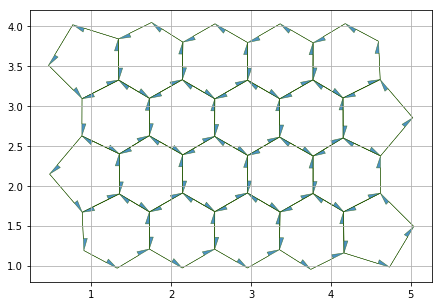

In [2]:
sheet = Sheet.planar_sheet_2d('division', 6, 6, 1, 1)
sheet.sanitize()
geom.update_all(sheet)

sheet.get_opposite()

# ## Set up the model
nondim_specs = config.dynamics.quasistatic_plane_spec()
dim_model_specs = model.dimensionalize(nondim_specs)
sheet.update_specs(dim_model_specs, reset=True)

print("Number of cells: {}\n"
      "          edges: {}\n"
      "          vertices: {}\n".format(sheet.Nf, sheet.Ne, sheet.Nv))

# ## Minimize energy
res = solver.find_energy_min(sheet, geom, model)

# ## View the result
draw_specs = config.draw.sheet_spec()
draw_specs['vert']['visible'] = False
draw_specs['edge']['head_width'] = 0.1
fig, ax = sheet_view(sheet, **draw_specs)
fig.set_size_inches(12, 5)

True


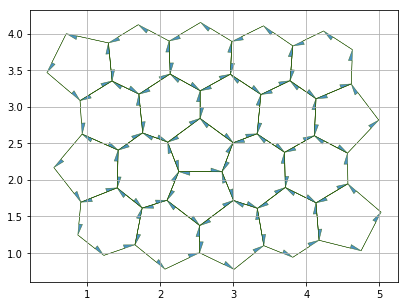

In [3]:
daughter = cell_division(sheet, 7, geom, angle=np.pi/2)

res = solver.find_energy_min(sheet, geom, model)
print(res['success'])

fig, ax = sheet_view(sheet, **draw_specs)
fig.set_size_inches(12, 5)

## Division in a 3D single layer epithelium

In [4]:
from tyssue.io.hdf5 import save_datasets, load_datasets
# redefine cell_division from monolayer related topology module
from tyssue.topology.monolayer_topology import cell_division

from tyssue.core.monolayer import Monolayer
from tyssue.geometry.bulk_geometry import BulkGeometry
from tyssue.dynamics.bulk_model import BulkModel#, set_model
#from tyssue.draw.vispy_draw import vp_view


In [5]:
datasets = load_datasets('../examples/small_ellipsoid.hf5',
                         data_names=['vert', 'edge',
                                     'face', 'cell'])

specs = config.geometry.bulk_spec()
monolayer = Monolayer('ell', datasets, specs)


In [6]:
mother = 8
daughter = cell_division(monolayer, mother, 
                         orientation='vertical')

monolayer.validate()

True

In [7]:

rho = np.linalg.norm(monolayer.vert_df[monolayer.coords], axis=1)
rho = pd.Series(rho, index=monolayer.vert_df.index)

colors = plt.cm.viridis(rho / rho.max())
draw_specs['edge']['color'] = colors
draw_specs['face']['color'] = '#aaaaaaaa'
ipv.clear()
fig, mesh = view_ipv(monolayer, 
                    coords=['z', 'x', 'y'], **draw_specs['edge'])
fig

Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array([[0.477504, 0.821444, 0.318195],
       [0.412913, 0.803041, 0.357269],
       [0.626579, 0.854645, 0.223353],
       [0.214   , 0.722114, 0.469588],
       [0.175707, 0.6979  , 0.491033],
       [0.239374, 0.735588, 0.455688],
       [0.458674, 0.816363, 0.329727],
       [0.150148, 0.676631, 0.506589],
       [0.150148, 0.676631, 0.506589],
       [0.19109 , 0.708366, 0.482284],
       [0.157851, 0.683765, 0.501686],
       [0.377779, 0.791781, 0.377939],
       [0.496615, 0.826376, 0.306377],
       [0.360741, 0.785964, 0.387814],
       [0.19109 , 0.708366, 0.482284],
       [0.545524, 0.838039, 0.275626],
       [0.555484, 0.840254, 0.269281],
       [0.162016, 0.687316, 0.499129],
       [0.175707, 0.6979  , 0.491033],
       [0.344074, 0.780029, 0.397381],
       [0.153894, 0.680203, 0.504172],
       [0.496615, 0.826376, 0.306377],
       [0.377779, 0.791781, 0.377939],
       [0.19109 , 0.708366, 0.482284],
       [0.430983, 0.808473, 0.346476],
       [0.14021 , 0.665859, 0.513427],
       [0.170948, 0.694384, 0.493803],
       [0.335885, 0.777018, 0.402049],
       [0.146616, 0.67305 , 0.508936],
       [0.535621, 0.835785, 0.281908],
       [0.386433, 0.794644, 0.372886],
       [0.19109 , 0.708366, 0.482284],
       [0.545524, 0.838039, 0.275626],
       [0.143303, 0.669459, 0.511215],
       [0.202219, 0.715272, 0.476084],
       [0.421908, 0.805774, 0.35191 ],
       [0.146616, 0.67305 , 0.508936],
       [0.535621, 0.835785, 0.281908],
       [0.369214, 0.788888, 0.382914],
       [0.185783, 0.704891, 0.485273],
       [0.626579, 0.854645, 0.223353],
       [0.157851, 0.683765, 0.501686],
       [0.214   , 0.722114, 0.469588],
       [0.440137, 0.811138, 0.340967],
       [0.150148, 0.676631, 0.506589],
       [0.487026, 0.823929, 0.312321],
       [0.344074, 0.780029, 0.397381],
       [0.185783, 0.704891, 0.485273],
       [0.575563, 0.844566, 0.256415],
       [0.153894, 0.680203, 0.504172],
       [0.185783, 0.704891, 0.485273],
       [0.360741, 0.785964, 0.387814],
       [0.150148, 0.676631, 0.506589],
       [0.487026, 0.823929, 0.312321],
       [0.377779, 0.791781, 0.377939],
       [0.185783, 0.704891, 0.485273],
       [0.440137, 0.811138, 0.340967],
       [0.14021 , 0.665859, 0.513427],
       [0.157851, 0.683765, 0.501686],
       [0.319809, 0.770914, 0.411152],
       [0.146616, 0.67305 , 0.508936],
       [0.535621, 0.835785, 0.281908],
       [0.395174, 0.797475, 0.367757],
       [0.196571, 0.711827, 0.479221],
       [0.82494 , 0.88472 , 0.106217],
       [0.741388, 0.873449, 0.149561],
       [0.804182, 0.882046, 0.114965],
       [0.730889, 0.871916, 0.156029],
       [0.720391, 0.87035 , 0.162603],
       [0.783315, 0.879285, 0.125405],
       [0.845561, 0.887322, 0.099702],
       [0.783315, 0.879285, 0.125405],
       [0.916242, 0.896091, 0.100717],
       [0.730889, 0.871916, 0.156029],
       [0.83527 , 0.886029, 0.102646],
       [0.730889, 0.871916, 0.156029],
       [0.720391, 0.87035 , 0.162603],
       [0.79376 , 0.880678, 0.120005],
       [0.741388, 0.873449, 0.149561],
       [0.79376 , 0.880678, 0.120005],
       [0.886271, 0.892374, 0.095374],
       [0.845561, 0.887322, 0.099702],
       [0.866013, 0.889868, 0.095953],
       [0.85581 , 0.888601, 0.097452],
       [0.85581 , 0.888601, 0.097452],
       [0.945636, 0.899815, 0.112838],
       [0.993248, 0.906157, 0.143936],
       [0.993248, 0.906157, 0.143936],
       [0.79376 , 0.880678, 0.120005],
       [0.79376 , 0.880678, 0.120005],
       [0.85581 , 0.888601, 0.097452],
       [0.935904, 0.89857 , 0.108131],
       [0.149039, 0.508051, 0.55725 ],
       [0.154815, 0.493313, 0.55784 ],
       [0.144759, 0.519093, 0.556572],
       [0.19943 , 0.387607, 0.5

In [8]:
mother = 18
daughter = cell_division(monolayer, mother, 
                         orientation='horizontal')
monolayer.validate()

True

In [9]:

rho = np.linalg.norm(monolayer.vert_df[monolayer.coords], axis=1)
rho = pd.Series(rho, index=monolayer.vert_df.index)

colors = plt.cm.viridis(rho / rho.max())
draw_specs['edge']['color'] = colors
draw_specs['face']['color'] = '#aaaaaaaa'


ipv.clear()
fig, mesh = view_ipv(monolayer, 
                    coords=['z', 'x', 'y'], **draw_specs['edge'])
fig

Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array([[0.477504, 0.821444, 0.318195],
       [0.412913, 0.803041, 0.357269],
       [0.626579, 0.854645, 0.223353],
       [0.214   , 0.722114, 0.469588],
       [0.175707, 0.6979  , 0.491033],
       [0.239374, 0.735588, 0.455688],
       [0.458674, 0.816363, 0.329727],
       [0.150148, 0.676631, 0.506589],
       [0.150148, 0.676631, 0.506589],
       [0.19109 , 0.708366, 0.482284],
       [0.157851, 0.683765, 0.501686],
       [0.377779, 0.791781, 0.377939],
       [0.496615, 0.826376, 0.306377],
       [0.360741, 0.785964, 0.387814],
       [0.19109 , 0.708366, 0.482284],
       [0.545524, 0.838039, 0.275626],
       [0.555484, 0.840254, 0.269281],
       [0.162016, 0.687316, 0.499129],
       [0.175707, 0.6979  , 0.491033],
       [0.344074, 0.780029, 0.397381],
       [0.153894, 0.680203, 0.504172],
       [0.496615, 0.826376, 0.306377],
       [0.377779, 0.791781, 0.377939],
       [0.19109 , 0.708366, 0.482284],
       [0.430983, 0.808473, 0.346476],
       [0.14021 , 0.665859, 0.513427],
       [0.170948, 0.694384, 0.493803],
       [0.335885, 0.777018, 0.402049],
       [0.146616, 0.67305 , 0.508936],
       [0.535621, 0.835785, 0.281908],
       [0.386433, 0.794644, 0.372886],
       [0.19109 , 0.708366, 0.482284],
       [0.545524, 0.838039, 0.275626],
       [0.143303, 0.669459, 0.511215],
       [0.202219, 0.715272, 0.476084],
       [0.421908, 0.805774, 0.35191 ],
       [0.146616, 0.67305 , 0.508936],
       [0.535621, 0.835785, 0.281908],
       [0.369214, 0.788888, 0.382914],
       [0.185783, 0.704891, 0.485273],
       [0.626579, 0.854645, 0.223353],
       [0.157851, 0.683765, 0.501686],
       [0.214   , 0.722114, 0.469588],
       [0.440137, 0.811138, 0.340967],
       [0.150148, 0.676631, 0.506589],
       [0.487026, 0.823929, 0.312321],
       [0.344074, 0.780029, 0.397381],
       [0.185783, 0.704891, 0.485273],
       [0.575563, 0.844566, 0.256415],
       [0.153894, 0.680203, 0.504172],
       [0.185783, 0.704891, 0.485273],
       [0.360741, 0.785964, 0.387814],
       [0.150148, 0.676631, 0.506589],
       [0.487026, 0.823929, 0.312321],
       [0.377779, 0.791781, 0.377939],
       [0.185783, 0.704891, 0.485273],
       [0.440137, 0.811138, 0.340967],
       [0.14021 , 0.665859, 0.513427],
       [0.157851, 0.683765, 0.501686],
       [0.319809, 0.770914, 0.411152],
       [0.146616, 0.67305 , 0.508936],
       [0.535621, 0.835785, 0.281908],
       [0.395174, 0.797475, 0.367757],
       [0.196571, 0.711827, 0.479221],
       [0.82494 , 0.88472 , 0.106217],
       [0.741388, 0.873449, 0.149561],
       [0.804182, 0.882046, 0.114965],
       [0.730889, 0.871916, 0.156029],
       [0.720391, 0.87035 , 0.162603],
       [0.783315, 0.879285, 0.125405],
       [0.845561, 0.887322, 0.099702],
       [0.783315, 0.879285, 0.125405],
       [0.916242, 0.896091, 0.100717],
       [0.730889, 0.871916, 0.156029],
       [0.83527 , 0.886029, 0.102646],
       [0.730889, 0.871916, 0.156029],
       [0.720391, 0.87035 , 0.162603],
       [0.79376 , 0.880678, 0.120005],
       [0.741388, 0.873449, 0.149561],
       [0.79376 , 0.880678, 0.120005],
       [0.886271, 0.892374, 0.095374],
       [0.845561, 0.887322, 0.099702],
       [0.866013, 0.889868, 0.095953],
       [0.85581 , 0.888601, 0.097452],
       [0.85581 , 0.888601, 0.097452],
       [0.945636, 0.899815, 0.112838],
       [0.993248, 0.906157, 0.143936],
       [0.993248, 0.906157, 0.143936],
       [0.79376 , 0.880678, 0.120005],
       [0.79376 , 0.880678, 0.120005],
       [0.85581 , 0.888601, 0.097452],
       [0.935904, 0.89857 , 0.108131],
       [0.149039, 0.508051, 0.55725 ],
       [0.154815, 0.493313, 0.55784 ],
       [0.144759, 0.519093, 0.556572],
       [0.19943 , 0.387607, 0.5

In [10]:
from tyssue.utils import single_cell

single = single_cell(monolayer, mother)


rho = np.linalg.norm(single.vert_df[single.coords], axis=1)
rho = pd.Series(rho, index=single.vert_df.index)

colors = plt.cm.viridis(rho / rho.max())
draw_specs['edge']['color'] = colors

draw_specs['face']['color'] = '#aaaaaaaa'
ipv.clear()
fig, mesh = view_ipv(single, 
                    coords=['z', 'x', 'y'], **draw_specs['edge'])
fig

Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array([[0.288921, 0.758394, 0.428426],
       [0.126326, 0.644107, 0.525311],
       [0.412913, 0.803041, 0.357269],
       [0.369214, 0.788888, 0.382914],
       [0.993248, 0.906157, 0.143936],
       [0.783315, 0.879285, 0.125405],
       [0.468053, 0.818921, 0.323998],
       [0.274149, 0.751988, 0.436601],
       [0.119738, 0.603785, 0.5414  ],
       [0.126326, 0.644107, 0.525311],
       [0.804182, 0.882046, 0.114965],
       [0.477504, 0.821444, 0.318195]]), lines=array([[10, 11],
       [ 4, 10],
       [11,  3],
       [ 3,  6],
       [ 5,  4],
       [ 6,  5],
       [11, 10],
       [10,  0],
       [ 1, 11],
       [10,  4],
       [ 4,  2],
       [ 0, 10],
       [ 3, 11],
       [11,  1],
       [ 8,  3],
       [ 6,  3],
       [ 3,  8],
       [ 9,  6],
       [ 4,  5],
       [ 5,  7],
       [ 2,  4],
       [ 5,  6],
       [ 6,  9],
       [ 7,  5],
       [ 7,  2],
       [ 9,  7],
       [ 0,  1],
       [ 8,  9],
       [ 1,  8],
       [ 2,  0],
       [ 7,  9],
       [ 9,  8],
       [ 8,  1],
       [ 1,  0],
       [ 0,  2],
       [ 2,  7]], dtype=uint32), texture=None, x=array([0.48730002, 0.23685842, 0.60124675, 0.11267021, 0.71314351,
       0.57071305, 0.28847935, 0.49685815, 0.11619586, 0.24550657,
       0.53826976, 0.27092614]), y=array([-0.38399775, -0.38634999, -0.45586724, -0.69387468, -0.66565779,
       -0.73180345, -0.75040727, -0.51037672, -0.49723925, -0.53604176,
       -0.54907385, -0.54223527]), z=array([ 3.71131019e-01,  3.78046889e-01,  2.01435965e-01,  2.87838443e-01,
        2.70807316e-01,  1.04341205e-04, -3.00632371e-03,  4.20016589e-03,
        2.02783204e-01, -1.93741244e-03,  5.32921337e-01,  5.32781460e-01]))], style={'axes': {'visible': False, 'label': {'color': 'white'}, 'ticklabel': {'color': 'white'}, 'color': 'white'}, 'box': {'visible': False}, 'background-color': 'black'}, tf=None, width=400, xlim=[-0.7804309316873469, 0.743167176810052], ylim=[-0.7804309316873469, 0.743167176810052], zlim=[-0.7804309316873469, 0.743167176810052])

#### Energy minimisation of the monolayer after division

> Note that this needs some more work

In [11]:
monolayer.update_specs(config.dynamics.quasistatic_bulk_spec())
monolayer.cell_df.loc[[mother, daughter], 'prefered_area'] /= 2
monolayer.cell_df.loc[[mother, daughter], 'prefered_vol'] /= 3

res = solver.find_energy_min(monolayer, BulkGeometry, BulkModel)
print(res['message'])
rho = np.linalg.norm(monolayer.vert_df[single.coords], axis=1)
rho = pd.Series(rho, index=monolayer.vert_df.index)

colors = plt.cm.viridis(rho / rho.max())
draw_specs['edge']['color'] = colors

draw_specs['face']['color'] = '#aaaaaaaa'
ipv.clear()
fig, mesh = view_ipv(monolayer, coords=['x', 'y', 'z'],
                     **draw_specs['edge'])
fig

/home/guillaume/miniconda3/envs/py36/lib/python3.6/site-packages/tyssue-0.2rc2-py3.6.egg/tyssue/dynamics/factory.py:80: UserWarning: setting ucoords in grad computation,please fix your specs
  warnings.warn('setting ucoords in grad computation,'


b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array([[0.83527 , 0.886029, 0.102646],
       [0.804182, 0.882046, 0.114965],
       [0.85581 , 0.888601, 0.097452],
       [0.730889, 0.871916, 0.156029],
       [0.688944, 0.865448, 0.182725],
       [0.688944, 0.865448, 0.182725],
       [0.783315, 0.879285, 0.125405],
       [0.699415, 0.867117, 0.175971],
       [0.709898, 0.868751, 0.169257],
       [0.772852, 0.877868, 0.131109],
       [0.720391, 0.87035 , 0.162603],
       [0.876168, 0.891125, 0.09525 ],
       [0.945636, 0.899815, 0.112838],
       [0.89632 , 0.893616, 0.096335],
       [0.79376 , 0.880678, 0.120005],
       [0.906311, 0.894855, 0.098125],
       [0.845561, 0.887322, 0.099702],
       [0.647257, 0.8584  , 0.209861],
       [0.668054, 0.861999, 0.196293],
       [0.783315, 0.879285, 0.125405],
       [0.668054, 0.861999, 0.196293],
       [0.876168, 0.891125, 0.09525 ],
       [0.688944, 0.865448, 0.182725],
       [0.626579, 0.854645, 0.223353],
       [0.82494 , 0.88472 , 0.106217],
       [0.585678, 0.846661, 0.249897],
       [0.626579, 0.854645, 0.223353],
       [0.751884, 0.874951, 0.143228],
       [0.565498, 0.84243 , 0.262877],
       [0.678489, 0.863742, 0.189503],
       [0.555484, 0.840254, 0.269281],
       [0.555484, 0.840254, 0.269281],
       [0.804182, 0.882046, 0.114965],
       [0.565498, 0.84243 , 0.262877],
       [0.616293, 0.852709, 0.230052],
       [0.751884, 0.874951, 0.143228],
       [0.555484, 0.840254, 0.269281],
       [0.585678, 0.846661, 0.249897],
       [0.585678, 0.846661, 0.249897],
       [0.575563, 0.844566, 0.256415],
       [0.83527 , 0.886029, 0.102646],
       [0.575563, 0.844566, 0.256415],
       [0.668054, 0.861999, 0.196293],
       [0.783315, 0.879285, 0.125405],
       [0.545524, 0.838039, 0.275626],
       [0.647257, 0.8584  , 0.209861],
       [0.626579, 0.854645, 0.223353],
       [0.585678, 0.846661, 0.249897],
       [0.83527 , 0.886029, 0.102646],
       [0.626579, 0.854645, 0.223353],
       [0.678489, 0.863742, 0.189503],
       [0.762373, 0.876424, 0.137064],
       [0.606045, 0.850733, 0.236712],
       [0.762373, 0.876424, 0.137064],
       [0.762373, 0.876424, 0.137064],
       [0.678489, 0.863742, 0.189503],
       [0.814576, 0.883393, 0.110347],
       [0.668054, 0.861999, 0.196293],
       [0.699415, 0.867117, 0.175971],
       [0.772852, 0.877868, 0.131109],
       [0.678489, 0.863742, 0.189503],
       [0.876168, 0.891125, 0.09525 ],
       [0.83527 , 0.886029, 0.102646],
       [0.741388, 0.873449, 0.149561],
       [0.906311, 0.894855, 0.098125],
       [0.974417, 0.90359 , 0.130215],
       [0.906311, 0.894855, 0.098125],
       [0.926106, 0.89733 , 0.104071],
       [0.876168, 0.891125, 0.09525 ],
       [0.741388, 0.873449, 0.149561],
       [0.876168, 0.891125, 0.09525 ],
       [0.699415, 0.867117, 0.175971],
       [0.89632 , 0.893616, 0.096335],
       [0.730889, 0.871916, 0.156029],
       [0.89632 , 0.893616, 0.096335],
       [0.845561, 0.887322, 0.099702],
       [0.876168, 0.891125, 0.09525 ],
       [0.9553  , 0.901065, 0.118128],
       [0.89632 , 0.893616, 0.096335],
       [0.974417, 0.90359 , 0.130215],
       [0.886271, 0.892374, 0.095374],
       [0.886271, 0.892374, 0.095374],
       [0.993248, 0.906157, 0.143936],
       [0.772852, 0.877868, 0.131109],
       [0.945636, 0.899815, 0.112838],
       [0.983868, 0.904867, 0.136897],
       [0.906311, 0.894855, 0.098125],
       [0.916242, 0.896091, 0.100717],
       [0.89632 , 0.893616, 0.096335],
       [0.89632 , 0.893616, 0.096335],
       [0.89632 , 0.893616, 0.096335],
       [0.926106, 0.89733 , 0.104071],
       [0.221989, 0.339161, 0.548752],
       [0.220057, 0.343307, 0.549413],
       [0.241237, 0.296485, 0.539709],
       [0.220057, 0.343307, 0.5

In [12]:
from tyssue.generation import three_faces_sheet, extrude
from tyssue.geometry.bulk_geometry import MonoLayerGeometry


datasets_2d, _ = three_faces_sheet(zaxis=True)
datasets = extrude(datasets_2d, method='translation')
eptm = Monolayer('test_volume', datasets, 
                 config.geometry.bulk_spec(),
                 coords=['x','y','z'])
#eptm.vert_df[eptm.coords] += np.random.normal(scale=1e-3,
#                                              size=eptm.vert_df[eptm.coords].shape)
MonoLayerGeometry.update_all(eptm)

for orientation in ['vertical', 'horizontal']:
    print(orientation)
    daughter = cell_division(eptm, 1,
                             orientation=orientation)
    eptm.reset_topo()
    eptm.reset_index()
    MonoLayerGeometry.update_all(eptm)
    print(f'Valid division for {orientation}:')
    print(eptm.validate()) #break

vertical
Valid division for vertical:
True
horizontal
Valid division for horizontal:
True
